In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
main_df = pd.read_csv("../data/animes_better.csv")
columns_to_drop = ['title', 'aired', 'episodes', 'members', 'ranked', 'score', 'link', 'img_url']
main_df = main_df.drop(columns=columns_to_drop)
main_df

,uid,synopsis,genre,popularity,Type,Producers,Studios,Source,Themes,Demographic,Duration,Favorites,Streaming Platforms
0,28891,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...",141,TV,"['Dentsu', 'Mainichi Broadcasting System', 'Mo...",['Production I.G'],Manga,"['School', 'Team Sports']",Shounen,24.0,15764,['Crunchyroll']
1,23273,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...",28,TV,"['Aniplex', 'Dentsu', 'Kodansha', 'Fuji TV', '...",['A-1 Pictures'],Manga,"['Love Polygon', 'Music', 'School']",Shounen,22.0,86357,"['Crunchyroll', 'Netflix']"
2,34599,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...",98,TV,"['AT-X', 'Takeshobo', 'Sony Music Communicatio...",['Kinema Citrus'],Web manga,['Theme Unknown'],Demographic Unknown,25.0,44597,"['Crunchyroll', 'HIDIVE', 'Netflix']"
3,5114,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...",4,TV,"['Aniplex', 'Square Enix', 'Mainichi Broadcast...",['Bones'],Manga,['Theme Unknown'],Shounen,24.0,227331,['Crunchyroll']
4,31758,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']",502,Movie,"['Aniplex', 'Kodansha']",['Shaft'],Light novel,['Theme Unknown'],Demographic Unknown,83.0,7588,['No Streaming Platform']
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16211,10075,All-new animation offered throughout UNIQLO cl...,"['Action', 'Comedy', 'Super Power', 'Martial A...",2382,OVA,['Producer Unknown'],['Pierrot'],Manga,['Theme Unknown'],Shounen,6.0,85,['No Streaming Platform']
16212,35828,High school student Sora Kashiwagi is accustom...,"['Slice of Life', 'Comedy', 'Supernatural']",1648,TV,"['TBS', 'Grooove', 'Nichion', 'Exit Tunes', 'O...",['8bit'],Web manga,"['Mythology', 'Pets', 'School']",Demographic Unknown,24.0,753,['Crunchyroll']
16213,10378,"After regaining her squid-like abilities, Ika ...","['Slice of Life', 'Comedy', 'Shounen']",1547,TV,"['TV Tokyo', 'Lantis', 'Pony Canyon', 'TV Toky...",['Diomedéa'],Manga,['Anthropomorphic'],Shounen,24.0,178,"['Crunchyroll', 'HIDIVE']"
16214,33082,"For years, the Niflheim Empire and the kingdom...",['Action'],2154,Movie,['Square Enix'],['Square Enix Visual Works'],Game,['Theme Unknown'],Demographic Unknown,115.0,154,['No Streaming Platform']


In [ ]:
stop_words = set(stopwords.words('english'))
stop_words.update(['anime','source'])



In [35]:
def sparse_corr(x, y):
    x = csr_matrix(x)
    mean_x = np.array(x.mean(axis=0)).flatten()
    mean_y = np.mean(y)
    y_centered = y - mean_y
    y_centered = csr_matrix(y_centered).T
    cov = np.array(x.multiply(y_centered).mean(axis=0)).flatten()
    std_x = np.sqrt(np.array(x.power(2).mean(axis=0) - np.square(mean_x)).flatten())
    std_y = np.std(y)
    corr = cov / (std_x * std_y)
    return corr

In [36]:
def one_hot_encode_chunk(df_chunk, categorical_columns):
    return pd.get_dummies(df_chunk, columns=categorical_columns)

def vectorize_synopsis_chunk(synopsis_chunk, vectorizer):
    return vectorizer.transform(synopsis_chunk)

In [37]:
for col in ['genre', 'Type', 'Producers', 'Studios', 'Source', 'Themes', 'Demographic', 'Streaming Platforms']:
    main_df[col] = main_df[col].apply(lambda x: ','.join(x) if isinstance(x, list) else x)

categorical_columns = ['genre', 'Type', 'Producers', 'Studios', 'Source', 'Themes', 'Demographic', 'Streaming Platforms']
chunks = np.array_split(main_df, 4)

with ThreadPoolExecutor() as executor:
    futures = [executor.submit(one_hot_encode_chunk, chunk, categorical_columns) for chunk in chunks]
    results = [f.result() for f in futures]

main_df_encoded = pd.concat(results)

e:\Python\GitHub\anime-data-analytics-project\venv\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [38]:
numeric_cols = main_df_encoded.select_dtypes(include=[np.number]).columns
non_numeric_cols = main_df_encoded.select_dtypes(exclude=[np.number]).columns

main_df_encoded[numeric_cols] = main_df_encoded[numeric_cols].fillna(main_df_encoded[numeric_cols].mean())
main_df_encoded[non_numeric_cols] = main_df_encoded[non_numeric_cols].fillna('Unknown')

main_df_encoded = main_df_encoded.apply(pd.to_numeric, errors='coerce').fillna(0)

In [40]:
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(), lowercase=True, token_pattern=None)
vectorizer.fit(main_df['synopsis'].dropna())

synopsis_chunks = np.array_split(main_df['synopsis'].fillna(''), 4)

with ThreadPoolExecutor() as executor:
    futures = [executor.submit(vectorize_synopsis_chunk, chunk, vectorizer) for chunk in synopsis_chunks]
    synopsis_matrices = [f.result() for f in futures]

synopsis_matrix = csr_matrix(synopsis_matrices[0])
for matrix in synopsis_matrices[1:]:
    synopsis_matrix = csr_matrix(np.vstack([synopsis_matrix.toarray(), matrix.toarray()]))

synopsis_features = vectorizer.get_feature_names_out()

e:\Python\GitHub\anime-data-analytics-project\venv\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [41]:
assert synopsis_matrix.shape[0] == len(main_df), "Shapes are inconsistent: {} != {}".format(synopsis_matrix.shape[0], len(main_df))

popularity = main_df['popularity'].values
synopsis_correlations = sparse_corr(synopsis_matrix, popularity)
synopsis_corr_df = pd.DataFrame({
    'keyword': synopsis_features,
    'correlation': synopsis_correlations
})

top_synopsis_keywords = synopsis_corr_df.reindex(synopsis_corr_df['correlation'].abs().sort_values(ascending=False).index).head(20)
top_synopsis_keywords_list = top_synopsis_keywords['keyword'].tolist()

top_synopsis_matrix = vectorizer.transform(main_df['synopsis'].fillna(''))
top_synopsis_matrix = top_synopsis_matrix[:, [vectorizer.vocabulary_[word] for word in top_synopsis_keywords_list]]

synopsis_keyword_df = pd.DataFrame(top_synopsis_matrix.toarray(), columns=top_synopsis_keywords_list)

In [43]:
final_features = pd.concat([main_df_encoded, synopsis_keyword_df], axis=1)
final_features = final_features.drop(columns=['uid', 'synopsis', 'popularity', 'Favorites'])

target = main_df['popularity']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(final_features, target, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [45]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 5519590.79057324
R^2 Score: 0.7535204537256632


In [46]:
feature_importances = pd.DataFrame({'Feature': final_features.columns, 'Importance': model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print(feature_importances.head(10))
print(feature_importances.tail(10))

                                             Feature  Importance
3566                      Studios_['Studio Unknown']    0.360384
10787                                       rewrite]    0.088941
4044                                Demographic_Kids    0.059247
10788                                       [written    0.042071
0                                           Duration    0.039159
4104   Streaming Platforms_['No Streaming Platform']    0.031141
3674                                  Source_Unknown    0.023033
10792                                            the    0.016159
2555                  Producers_['Producer Unknown']    0.012298
3670                                 Source_Original    0.011188
                                                Feature  Importance
2098  Producers_['Frontier Works', 'AT-X', 'Magic Ca...         0.0
9206            genre_['Cars', 'Game', 'Kids', 'Mecha']         0.0
2099  Producers_['Frontier Works', 'AT-X', 'Nippon C...         0.0
4957  genre_[

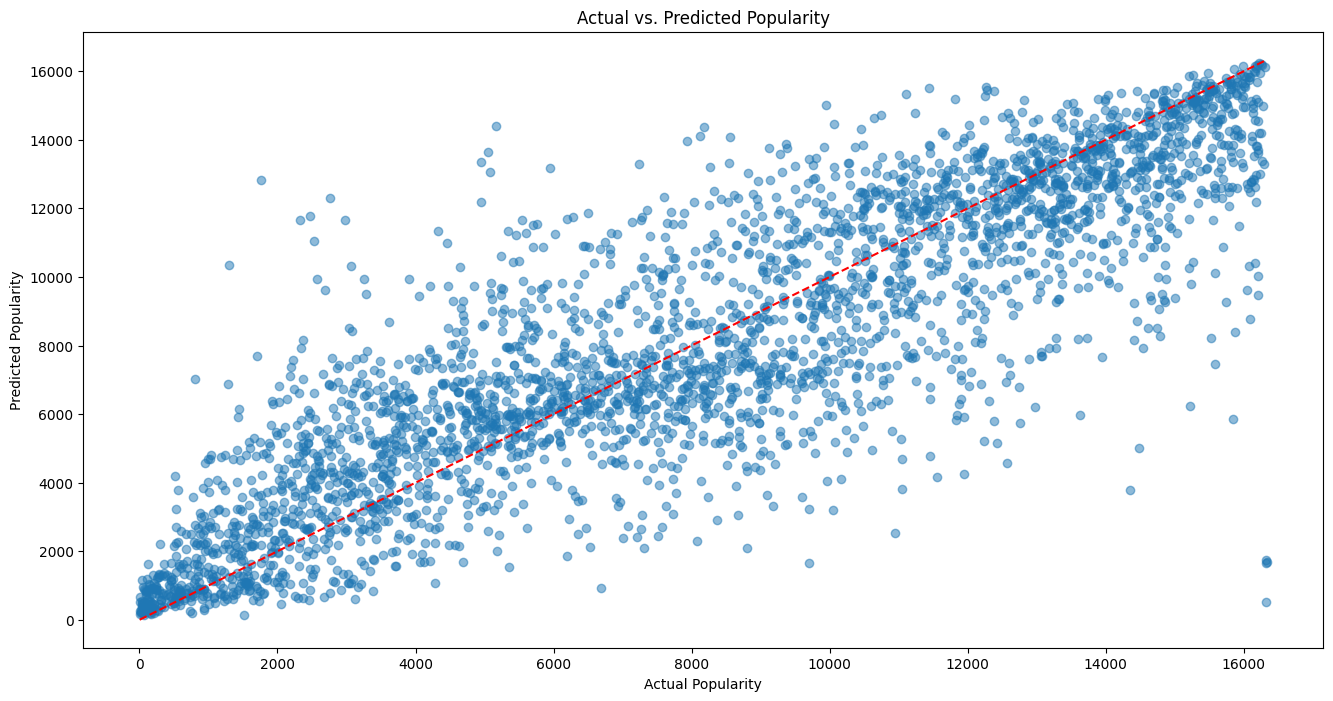

In [47]:
plt.figure(figsize=(16, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Actual vs. Predicted Popularity')
plt.show()

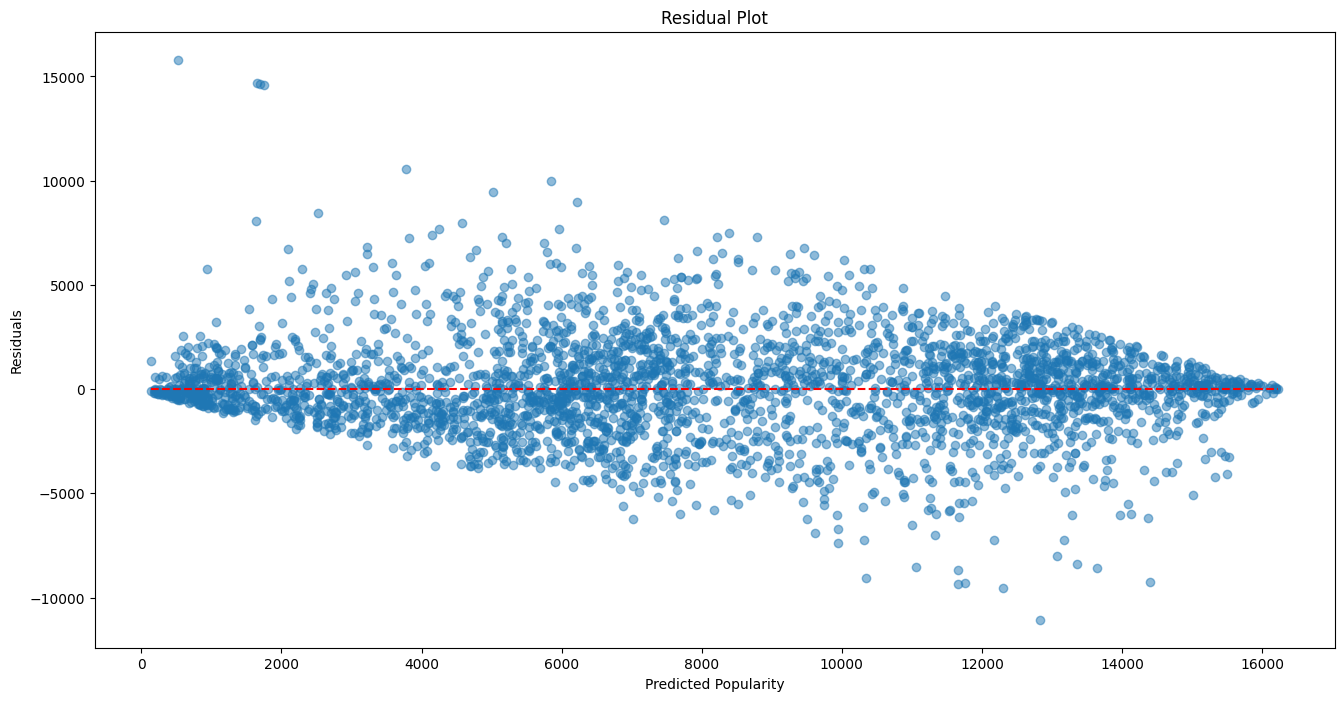

In [48]:
residuals = y_test - y_pred
plt.figure(figsize=(16, 8))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), color='red', linestyle='--')
plt.xlabel('Predicted Popularity')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

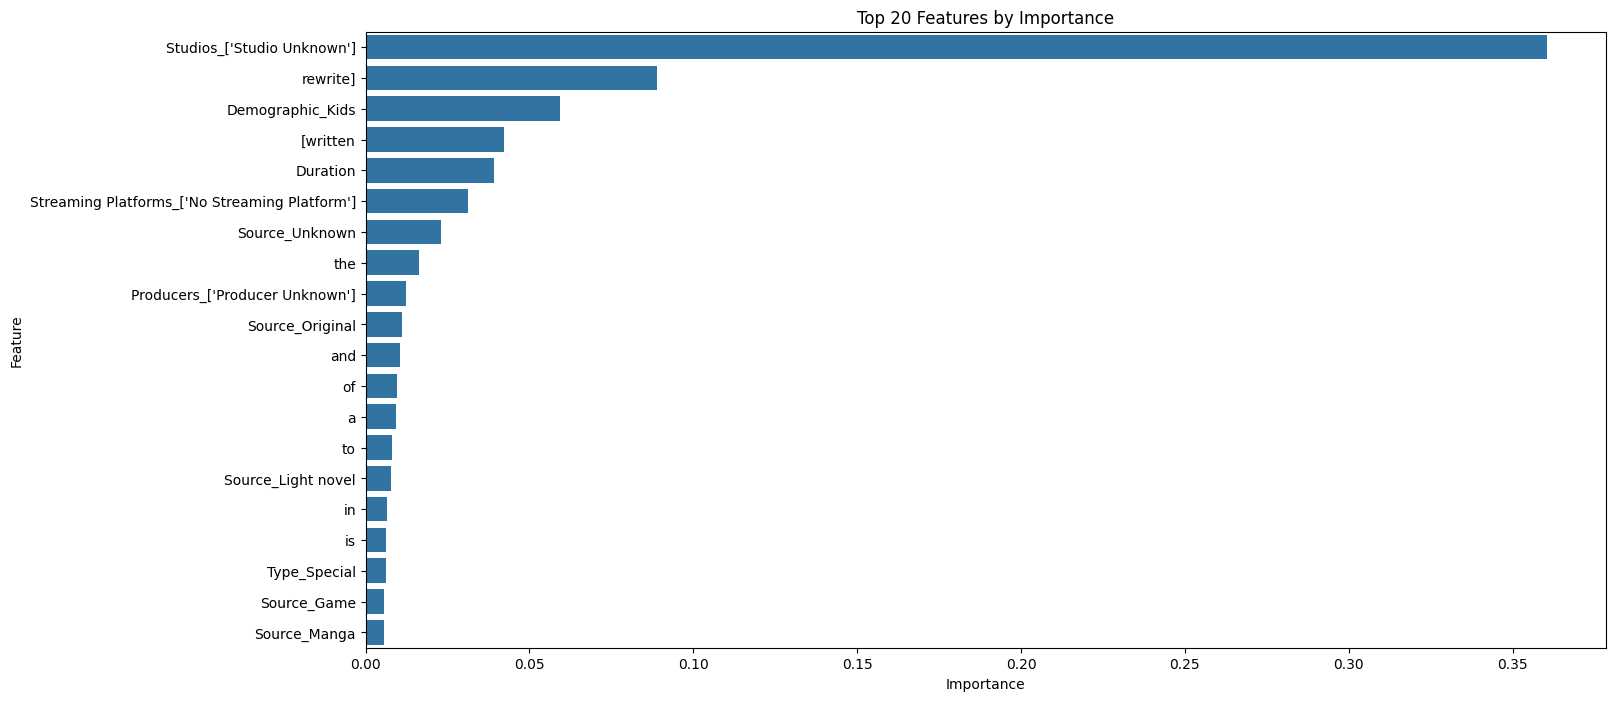

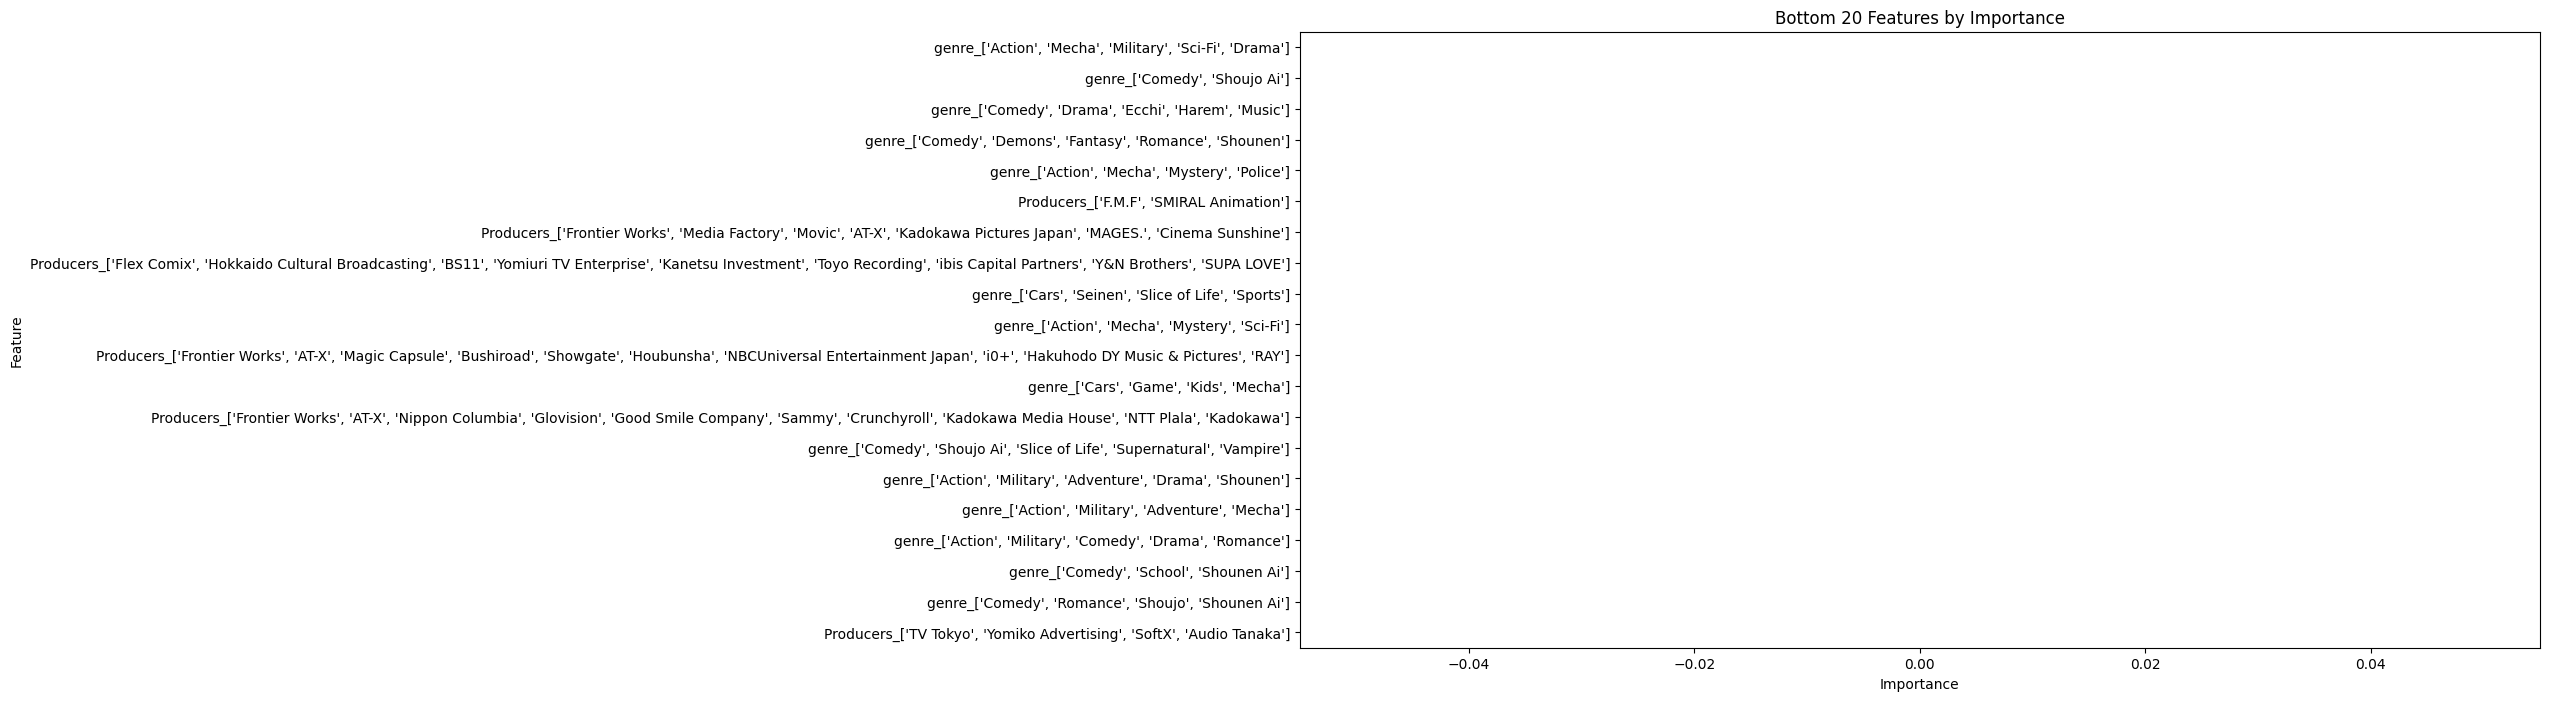

In [49]:
plt.figure(figsize=(16, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20))
plt.title('Top 20 Features by Importance')
plt.show()

plt.figure(figsize=(16, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.tail(20))
plt.title('Bottom 20 Features by Importance')
plt.show()